In [112]:
cd /home/disk2/wdd/PDZ/12concentration_MSM_Q0821/

/home/disk2/wdd/PDZ/12concentration_MSM_Q0821


In [1]:
import sys
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
from msmbuilder.lumping import PCCA
from msmbuilder.msm import implied_timescales
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/disk2/wdd/msm/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
trj_information=np.loadtxt('trj_select2.cs')

In [4]:
all_Q=[]
for eachin in trj_information:
    #print eachin[0]
    filename='/home/disk2/wdd/PDZ/12concentration_MSM_Q/h5/Qall/fit'+str(int(eachin[0]))+'_chain'+str(int(eachin[1]))+'_Q_s.h5'
    endtrj=int(eachin[2])*10+1
    Q = dataset(filename)
    all_Q.append(Q[0][0:endtrj])
    del Q
all_arr=np.array(all_Q)

In [49]:
from msmbuilder.cluster import KMeans

In [105]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=50, n_components=6)
tica_model.fit(all_arr)
tica_trajs = tica_model.transform(all_arr)

In [109]:
clusterer = KCenters(n_clusters=300)
clustered_trajs = clusterer.fit_transform(tica_trajs)

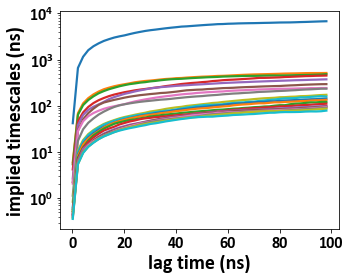

In [80]:
tlag=100
ncom=6
nc=400
lag_times = np.arange(1,1000,20)
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
#plt.ylim(1,10000)
plt.semilogy()
pngname='impliedtimescales_kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)
plt.savefig(pngname,dpi=600,bbox_inches='tight')
plt.show()

In [110]:
msm=MarkovStateModel(lag_time=500,reversible_type='mle', ergodic_cutoff='on',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')

In [95]:
alllist=[]
for i in range(len(clustered_trajs)):
    alllist+=list(clustered_trajs[i])
print len(set(alllist))

400


In [113]:
msm.score(lab_fix)

19.94981849193573

In [79]:
os.chdir('/home/disk2/wdd/PDZ/12concentration_MSM_Q0824')
tica_lag=[100]
num_components=[8]
num_clusters=[300,450,500,600,800,900]
lagtime=[500]
for tlag in tica_lag:
    wf.write(str(tlag)+'    ')
    for ncom in num_components:
        wf.write(str(ncom)+'    ')
        tica_model = tICA(lag_time=tlag, n_components=ncom,kinetic_mapping=True)
        #tica_model = tICA(lag_time=tlag, n_components=ncom)
        #tica_dir='ticas_lag'+str(tlag)+'ncom'+str(ncom)+'/'
        #tica_model = scaled_diheds.fit_with(tica_model)
        tica_model.fit(all_arr)
        tica_trajs = tica_model.transform(all_arr)
        #tica_trajs = scaled_diheds.transform_with(tica_model, tica_dir, fmt='dir-npy')
        for nc in num_clusters:
            wf.write(str(nc)+'    ')
            clusterer = KCenters(n_clusters=nc, random_state=42)
            #cluster_dir='kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)+'/'
            #clustered_trajs = tica_trajs.fit_transform_with(clusterer, cluster_dir, fmt='dir-npy')
            clustered_trajs = clusterer.fit_transform(tica_trajs)
            for lg in lagtime:
                msm=MarkovStateModel(lag_time=lg,reversible_type='mle', ergodic_cutoff='on',verbose=False)
                msm.fit(clustered_trajs)
                lab_fix=msm.transform(clustered_trajs,mode='fill')
                os.chdir('/home/disk2/wdd/PDZ/12concentration_MSM_Q0821')
                dirname='micro'+str(nc)+'_la'+str(lg)+'_tica'+str(ncom)+'lag'+str(tlag)
                os.mkdir(dirname)
                os.chdir(dirname)
                wf=open('Populations.dat','w')
                for h in msm.populations_:
                    wf.write(str(h)+'\n')
                wf.close()
                
                matrix = msm.transmat_
                wf=open('matrix.dat','w')
                for h in matrix:
                    for l in h:
                        wf.write(str(l)+'    ')
                    wf.write('\n')
                wf.close()
                save_meta(clustered_trajs,'clustered_trajs.pickl')
                save_meta(msm,'msm.pickl')
                os.system('/home/disk2/wdd/msm_tools/CKtestV5 -msm msm.pickl -clu clustered_trajs.pickl -dt 10 -T 6')

In [48]:
len(clustered_trajs[0])

4001

In [119]:
cd /home/disk2/wdd/PDZ/12concentration_MSM_Q0821/micro300_la700_tica8lag100

/home/disk2/wdd/PDZ/12concentration_MSM_Q0821/micro300_la700_tica8lag100


In [ ]:
os.system('/home/disk2/wdd/msm_tools/CKtestV5 -msm msm.pickl -clu clustered_trajs.pickl -dt 10 -T 6')

In [18]:
os.chdir('/home/disk2/wdd/PDZ/12concentration_MSM_Q0818')
msm=MarkovStateModel(lag_time=500,reversible_type='mle', ergodic_cutoff='off',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')
os.mkdir('micro800_la500_tica8lag10')
os.chdir('micro800_la500_tica8lag10')
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')

In [36]:
msm.score(lab_fix)

227.5390625

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/msmbuilder-3.8.0-py2.7-linux-x86_64.egg/msmbuilder/decomposition/tica.py:411: UserWarning: length of data (1) is too short for the lag time (20)
  warnings.warn("length of data (%d) is too short for the lag time (%d)" % (len(X), self.lag_time))


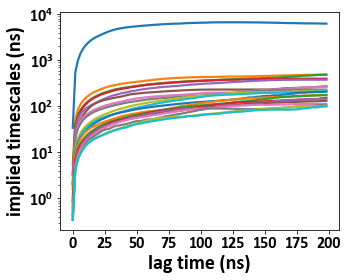

In [37]:
tlag=20
ncom=7
nc=750
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=tlag, n_components=ncom)
tica_model.fit(all_arr)
tica_trajs = tica_model.transform(all_arr)
clusterer = MiniBatchKMedoids(n_clusters=nc, random_state=42)
clustered_trajs = clusterer.fit_transform(tica_trajs)
lag_times = np.arange(1,2000,20)
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
#plt.ylim(1,10000)
plt.semilogy()
pngname='impliedtimescales_kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)
plt.savefig(pngname,dpi=600,bbox_inches='tight')
plt.show()

In [40]:
os.chdir('/home/disk2/wdd/PDZ/12concentration_MSM_Q0818')
msm=MarkovStateModel(lag_time=700,reversible_type='mle', ergodic_cutoff='off',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')
os.mkdir('micro750_la700_tica7lag20')
os.chdir('micro750_la700_tica7lag20')
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')

In [41]:
msm.score(lab_fix)

-134.9423828125

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/msmbuilder-3.8.0-py2.7-linux-x86_64.egg/msmbuilder/decomposition/tica.py:411: UserWarning: length of data (1) is too short for the lag time (8)
  warnings.warn("length of data (%d) is too short for the lag time (%d)" % (len(X), self.lag_time))


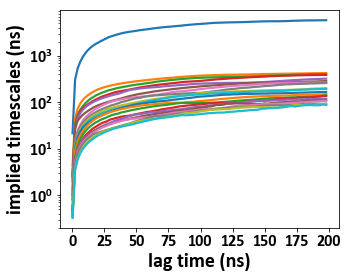

In [42]:
tlag=8
ncom=8
nc=650
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=tlag, n_components=ncom)
tica_model.fit(all_arr)
tica_trajs = tica_model.transform(all_arr)
clusterer = MiniBatchKMedoids(n_clusters=nc, random_state=42)
clustered_trajs = clusterer.fit_transform(tica_trajs)
lag_times = np.arange(1,2000,20)
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*0.1, msm_timescales[:,i]*0.1,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ns)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ns)',fontproperties=font_prop)
#plt.ylim(1,10000)
plt.semilogy()
pngname='impliedtimescales_kmedoids'+str(tlag)+'ncom'+str(ncom)+'c'+str(nc)
plt.savefig(pngname,dpi=600,bbox_inches='tight')
plt.show()

In [43]:
os.chdir('/home/disk2/wdd/PDZ/12concentration_MSM_Q0818')
msm=MarkovStateModel(lag_time=700,reversible_type='mle', ergodic_cutoff='off',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')
os.mkdir('micro650_la700_tica8lag8')
os.chdir('micro650_la700_tica8lag8')
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')
msm.score(lab_fix)

-49.017578125

500
17.3784936976
500
21.5351469815
500
21.5190623317
500


/software/anaconda2/envs/msmb/lib/python2.7/site-packages/msmbuilder-3.8.0-py2.7-linux-x86_64.egg/msmbuilder/msm/msm.py:451: ComplexWarning: Casting complex values to real discards the imaginary part
  mapped_V[dest_indices, :] = np.take(V, source_indices, axis=0)


nan
500
nan
500
nan


In [118]:
msm.score(lab_fix)

nan

In [56]:
os.chdir('/home/disk2/wdd/PDZ/12concentration_MSM_Q0818')
msm=MarkovStateModel(lag_time=500,reversible_type='mle', ergodic_cutoff='off',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')
os.mkdir('micro150_la600_tica8lag100')
os.chdir('micro150_la600_tica8lag100')
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')

In [75]:
msm=MarkovStateModel(lag_time=50,reversible_type='mle', ergodic_cutoff='on',verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')

In [76]:
len(msm.populations_)

66

In [70]:
print msm.summarize()

Markov state model
------------------
Lag time         : 800
Reversible type  : mle
Ergodic cutoff   : off
Prior counts     : 0

Number of states : 66
Number of nonzero entries in counts matrix : 3327 (76.3774104683%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.0
    Median : 0.0
    Mean   : 2.2
    3rd Qu.: 0.1
    Max.   : 6191.7

Total transition counts :
    7280.1525 counts
Total transition counts / lag_time:
    9.100190625 units
Timescales:
    [42219.54, 3863.88, 3783.90, 2812.58, 2535.54, 1688.91, 1047.05, 939.09, 878.05, 839.07, 658.61, 607.02, 542.25, 523.27, 521.26, 468.56, 430.32, 420.84, 401.61, 373.76, 356.14, 349.82, 337.70, 330.96, 320.51, 299.84, 296.00, 288.40, 281.33, 271.66, 265.87, 259.79, 251.15, 247.61, 241.10, 221.40, 213.16, 209.16, 203.88, 200.92, 189.62, 179.93, 176.54, 166.81, 166.39, 159.49, 156.68, 149.52, 138.45, 132.31, 121.65, 104.05, 99.71, 73.52, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]  units



In [72]:
len(tica_trajs)

756

In [90]:
import pandas as pd

In [92]:
msmff=pd.read_pickle('msm.pickl')